In [519]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.stats import kstest, norm, probplot
from sklearn.model_selection import train_test_split
from sklearn.mixture import GaussianMixture
from sklearn.neighbors import KernelDensity
from math import log, pi, exp, sqrt
from sklearn.metrics import confusion_matrix

### Data Loading and Preprocessing

This code snippet performs the following steps:

- Loads the dataset from a whitespace-separated text file without headers.
- Assigns meaningful column names to the dataset.
- Splits the data into features (`X`) and the target variable (`y`).
- Splits the dataset into training and testing subsets, with 30% of the data reserved for testing.
- Separates the features into discrete (categorical) and continuous (numerical) groups for subsequent processing.

In [520]:
data = pd.read_csv('lifeInsurance.txt', header = None, sep= '\s+')
data.columns = ['Gender', 'Age', 'MaritalStatus', 'NumberOfChildren', 'PhysicalStatus', 'ChronicDiseases', 'MonthlySalary', 'Decision']

# Extracting the features and target variable
X = data.drop(columns=["Decision"])
y = data['Decision']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Separate the discrete and continuous features
discrete_features = ['Gender', 'MaritalStatus', 'NumberOfChildren', 'PhysicalStatus', 'ChronicDiseases']
continuous_features = ['Age', 'MonthlySalary']

## Prior Probability Calculation Function

The function `prior_probabilities` computes the prior probabilities of each class label in the input vector `y`.

- It counts the occurrences of each unique class in the provided `y` (in this case, `y_train`).
- It calculates the probability of each class by dividing its count by the total number of elements in `y_train`.
- It returns a dictionary where the keys are the class labels and the values are their respective prior probabilities.

By applying this function to `y_train`, it estimates how likely each class is to appear in the training dataset before considering any features.


In [521]:
# Function to calculate prior probabilities for each class label in y
def prior_probabilities(y):
    # Get the total number of elements in y
    total = y.shape[0]
    
    # Create an empty dictionary to store the probabilities
    probabilities = {}

    # Loop through each unique value (class) in y
    for value in y.unique():
        # Count how many times the class appears and divide by total to get the probability
        probabilities[value] = y[y == value].shape[0] / total

    # Return the dictionary with prior probabilities
    return probabilities

# Call the function with y and store the result
prior_prob = prior_probabilities(y_train)

# Print the prior probabilities
print('Prior probabilities:')
for p, value in prior_prob.items():
    # Display each class and its probability formatted to 4 decimal places
    print(f'  P({p}) = {value:.4f} %')

Prior probabilities:
  P(0.0) = 0.6714 %
  P(1.0) = 0.3286 %


## Conditional Probability for Discrete Features

The function `conditional_probabilities_discrete` calculates the conditional probabilities **P(feature value | class label)** for each discrete feature in the dataset, applying **Laplace smoothing** to avoid zero probabilities for unseen feature-value/class combinations.

It returns a nested dictionary storing, for each discrete feature and each possible feature value, the smoothed probability of observing that feature value given a particular class label.


In [522]:
# Function to compute conditional probabilities P(feature_value | class) for discrete features
def conditional_probabilities_discrete(X, y, discrete_features):
    probabilities = {}  # Initialize an empty dictionary to store probabilities

    # Loop through each discrete feature
    for feature in discrete_features:
        probabilities[feature] = {}  # Initialize a dictionary for each feature

        # Get all unique values of the feature
        unique_values = X[feature].unique()
        num_unique_values = len(unique_values)

        for value in unique_values:
            probabilities[feature][value] = {}  # Initialize a dictionary for each value of the feature

            # Loop through each unique decision in y
            for decision in y.unique():
                subset = X[(X[feature] == value) & (y == decision)]  # Filter the DataFrame for the current feature value and decision

                num_samples = subset.shape[0]  # Count the number of samples for the current feature value and decision
                num_decision_samples = y[y == decision].shape[0]  # Count the total number of samples for the current decision

                # Apply Laplace smoothing to avoid division by zero
                numerator = num_samples + 1
                denominator = num_decision_samples + num_unique_values

                # Calculate the conditional probability P(feature_value | decision) with Laplace smoothing
                probabilities[feature][value][decision] = numerator / denominator if num_decision_samples > 0 else 0

    return probabilities

## Likelihood Calculation for Discrete Features

The function `likelihood_discrete` calculates the likelihood of a given instance belonging to each class label based on the product of conditional probabilities of its discrete feature values. 

It returns a dictionary where each key is a class label and each value is the corresponding likelihood for that class.

In [523]:
# Function to calculate the likelihood for a given instance based on discrete feature probabilities
def likelihood_discrete(prob_discrete, X, y, instance):
    # Initialize a dictionary to store likelihoods for each class
    likelihoods = {}

    # Iterate over each unique decision in y to calculate likelihoods
    for decision in y.unique():
        likelihoods[decision] = 1  # Start with a likelihood of 1 for each decision

        # For each discrete feature, multiply the likelihood by the conditional probability
        for feature in discrete_features:
            value = instance[feature]  # Get the value of the feature for the instance
            likelihoods[decision] *= prob_discrete[feature][value][decision]  # Multiply by the conditional probability for this feature and decision

    return likelihoods

## Gaussian Distribution Check for Continuous Features

The function `check_if_gaussian` checks whether each continuous feature follows a Gaussian (normal) distribution within each class of the target variable `y`.

It uses the **Kolmogorov–Smirnov (KS) test** on standardized data for each feature/class pair and displays:
- The KS test statistic and p-value.
- A **histogram with KDE** to visualize the feature’s distribution.
- A **Q–Q plot** to visually assess normality.

If the p-value is greater than 0.05, the feature is considered likely Gaussian for that class.

Checking if Age is Gaussian...
  Class: 0.0 | KS Statistic: 0.1244, p-value: 0.0003
    The feature Age is not Gaussian.


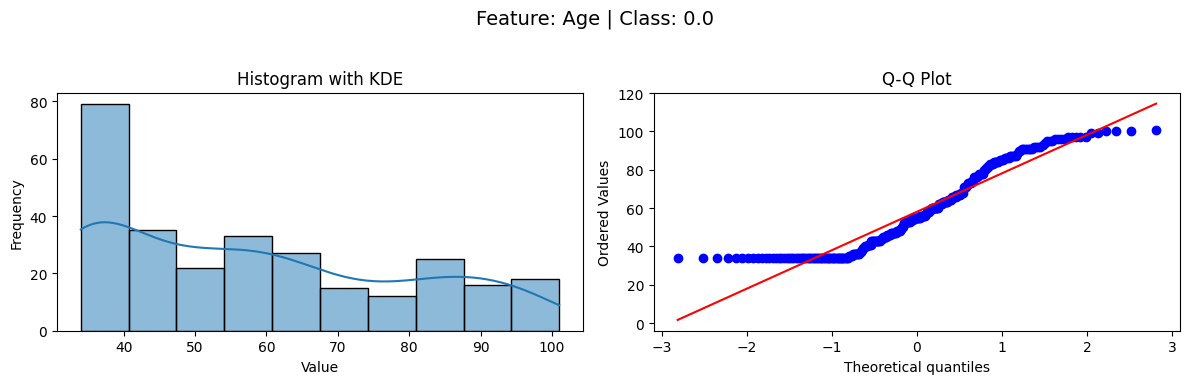

  Class: 1.0 | KS Statistic: 0.1050, p-value: 0.0885
    The feature Age is likely Gaussian.


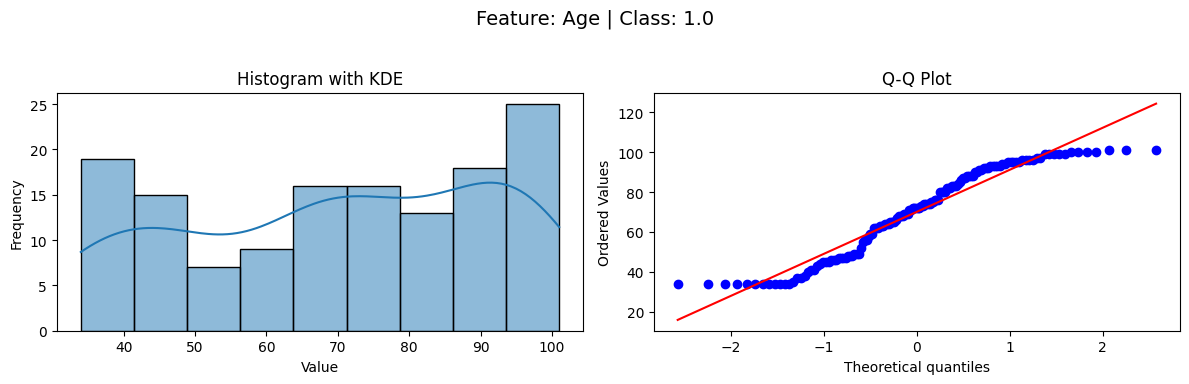

Checking if MonthlySalary is Gaussian...
  Class: 0.0 | KS Statistic: 0.0834, p-value: 0.0372
    The feature MonthlySalary is not Gaussian.


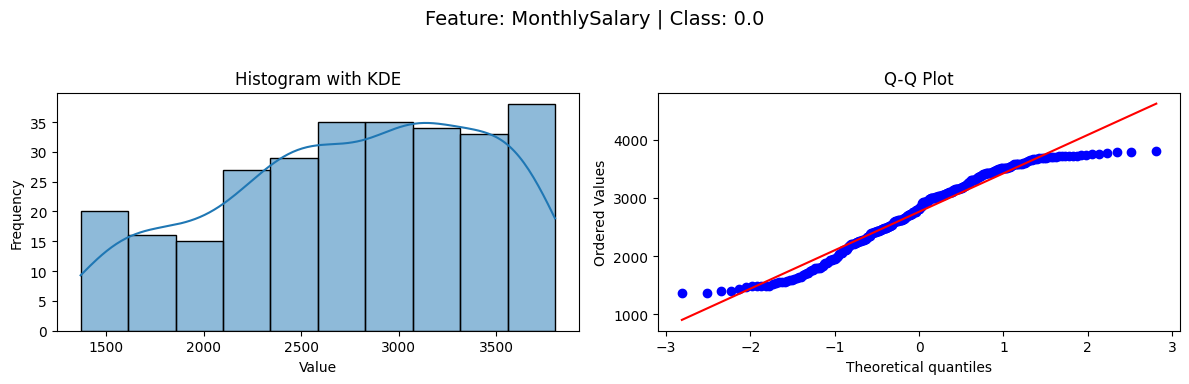

  Class: 1.0 | KS Statistic: 0.0826, p-value: 0.2865
    The feature MonthlySalary is likely Gaussian.


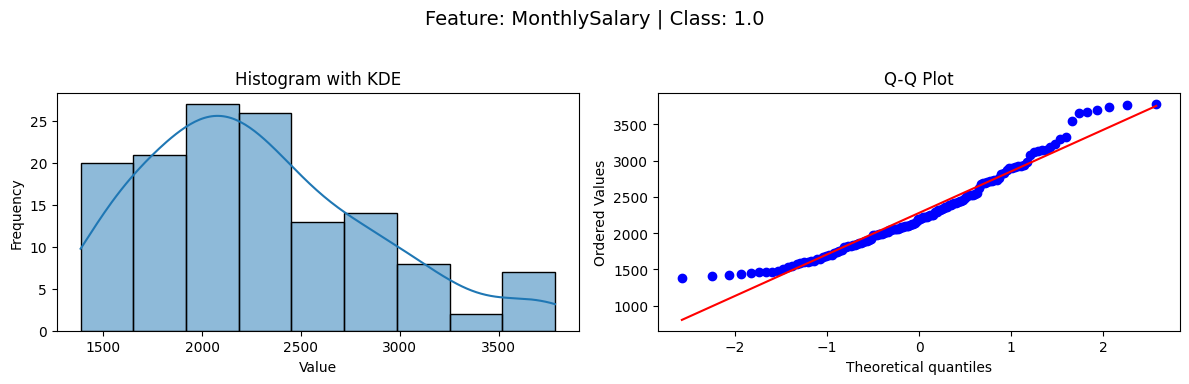

Only 2 out of 4 continuous features are Gaussian.


In [524]:
# Function to check if each continuous feature follows a Gaussian distribution for each class
def check_if_gaussian(continuous_features, X, y):
    size = len(continuous_features) * y.nunique()  # Get the number of continuous features multiplied by the number of unique decisions in y
    n_gaussian = 0  # Initialize a counter for Gaussian features

    # Loop through each continuous feature
    for feature in continuous_features:
        print(f"Checking if {feature} is Gaussian...")

        # Loop through each unique decision in y
        for decision in y.unique():
            subset = X[y == decision][feature]  # Filter the DataFrame for the current decision

            # Check if there are enough samples to perform the test
            if len(subset) < 5:
                print(f"  Class: {decision} | Not enough data to test.")
                continue

            mean = subset.mean()  # Calculate the mean of the subset
            std = subset.std()  # Calculate the standard deviation of the subset
            standardized_data = (subset - mean) / std  # Standardize the data. Mean = 0, Std = 1

            stat, p_value = kstest(standardized_data, 'norm')  # Perform the Kolmogorov-Smirnov test

            # Print the results of the test
            print(f"  Class: {decision} | KS Statistic: {stat:.4f}, p-value: {p_value:.4f}")
            if p_value > 0.05:
                print(f"    The feature {feature} is likely Gaussian.")
                n_gaussian += 1
            else:
                print(f"    The feature {feature} is not Gaussian.")

            # Visualization: Histogram and Q–Q plot
            fig, axes = plt.subplots(1, 2, figsize=(12, 4))
            fig.suptitle(f"Feature: {feature} | Class: {decision}", fontsize=14)

            # Plot histogram with kernel density estimate (KDE) - helps visualize the distribution
            sns.histplot(subset, kde=True, ax=axes[0])
            axes[0].set_title("Histogram with KDE")
            axes[0].set_xlabel("Value")
            axes[0].set_ylabel("Frequency")

            # Q–Q plot - compares the quantiles of the data against a normal distribution
            # If the points lie on the line, the data is normally distributed
            probplot(subset, dist="norm", plot=axes[1])
            axes[1].set_title("Q-Q Plot")

            plt.tight_layout(rect=[0, 0.03, 1, 0.95])
            plt.show()

    if n_gaussian == size:
        return True
    else:
        print(f"Only {n_gaussian} out of {size} continuous features are Gaussian.")
        return False

gaussian = check_if_gaussian(continuous_features, X_train, y_train)

## Mean and Standard Deviation for Continuous Features

The function `mean_std_continuous` calculates the **mean** and **standard deviation** of each continuous feature, separately for every class in the target variable `y_train`.

**Purpose:** This is useful for models that assume features follow a **Gaussian distribution** per class (e.g., Gaussian Naive Bayes), where the likelihood is computed using these statistics.

In [525]:
# Function to compute the mean and standard deviation of continuous features for each class
def mean_std_continuous(X, y):
    mean_std = {}  # Initialize an empty dictionary to store probabilities

    # Loop through each continuous feature
    for feature in continuous_features:
        mean_std[feature] = {}  # Initialize a dictionary for each continuous feature

        # Loop through each unique decision in y
        for decision in y.unique():
            subset = X[y == decision][feature]  # Filter the DataFrame for the current decision
            mean = subset.mean()  # Calculate the mean of the feature for the current decision
            std = subset.std()  # Calculate the standard deviation of the feature for the current decision

            # Store the mean and standard deviation in the dictionary
            mean_std[feature][decision] = (mean, std)

    return mean_std

print('Mean and standard deviation for continuous features:')
mean_std = mean_std_continuous(X_train, y_train)
for feature, decisions in mean_std.items():
    print(f"  Feature: {feature}")
    for decision, (mean, variance) in decisions.items():
        print(f"    Decision: {decision}, Mean: {mean:.4f}, Variance: {variance:.4f}")
    print()

Mean and standard deviation for continuous features:
  Feature: Age
    Decision: 0.0, Mean: 58.0993, Variance: 20.8981
    Decision: 1.0, Mean: 70.1232, Variance: 21.5130

  Feature: MonthlySalary
    Decision: 0.0, Mean: 2763.2344, Variance: 669.6549
    Decision: 1.0, Mean: 2279.5887, Variance: 578.4760



## Conditional Probability Estimation for Continuous Features

To compute the conditional probabilities of continuous features, we will explore the following methods:

- **Gaussian PDF**
- **Discretization**  
- **Gaussian Mixture Models (GMM)**  
- **Kernel Density Estimation (KDE)**
---

### Normal Probability Density Function (Gaussian PDF)  
The normal probability density function assumes that continuous features follow a Gaussian distribution characterized by a mean (`μ`) and standard deviation (`σ`). It calculates the likelihood of observing a specific value based on this distribution. This method is simple and computationally efficient but relies on the assumption that the data is approximately normally distributed.

Mathematically, it is defined as:

$$
P(x \mid \mu, \sigma) = \frac{1}{\sqrt{2\pi\sigma^2}} \cdot e^{ -\frac{(x - \mu)^2}{2\sigma^2} }
$$

In [526]:
# Function to calculate the conditional probabilities of continuous features
# given a data instance, using the normal distribution
# This function assumes that the continuous features follow a Gaussian distribution
def conditional_probabilities_continuous_gaussian(mean_std, X, y, instance):
    probabilities = {}  # Initialize an empty dictionary to store probabilities

    # Loop through each continuous feature
    for feature in continuous_features:
        probabilities[feature] = {}  # Initialize a dictionary for each continuous feature

        # Loop through each unique decision in y
        for decision in y.unique():
            mean, std = mean_std[feature][decision]  # Get the mean and standard deviation for the feature and decision
            value = instance[feature]  # Get the value of the feature for the instance

            prob = norm.pdf(value, loc=mean, scale=std)  # Calculate the probability using the normal PDF

            probabilities[feature][decision] = prob  # Store the probability in the dictionary

    return probabilities

#### Likelihood Calculation Using Gaussian Probabilities  
After computing the conditional probabilities of each continuous feature using the Gaussian PDF, this function combines them to calculate the overall likelihood of an instance belonging to each class.

It assumes that the features are conditionally independent given the class (as in the Naive Bayes assumption), and multiplies the individual probabilities together to form the total likelihood for each decision class.

This process follows:

$$
P(x_1, x_2, \dots, x_n \mid C_k) = \prod_{i=1}^{n} P(x_i \mid C_k)
$$

Where:
- \( x_i \) is the value of the \( i \)-th continuous feature,
- \( C_k \) is the \( k \)-th class,
- \( P(x_i \mid C_k) \) is obtained from the Gaussian PDF.


In [527]:
# Function to calculate the likelihood for a given instance based on continuous feature probabilities
def likelihood_continuous_gaussian(probabilities, X, y):
    likelihoods = {}  # Initialize a dictionary to store likelihoods for each class

    # Iterate over each unique decision in y to calculate likelihoods
    for decision in y.unique():
        likelihoods[decision] = 1  # Start with a likelihood of 1 for each decision

        # For each continuous feature, multiply the likelihood by the conditional probability
        for feature in continuous_features:
            prob = probabilities[feature][decision]
            likelihoods[decision] *= prob  # Multiply by the conditional probability for this feature and decision
    
    return likelihoods

#### Gaussian Naive Bayes Prediction for Mixed Features

This function implements the prediction step of a **Naive Bayes classifier** that handles both **discrete** and **continuous** features. For continuous features, it assumes a **Gaussian (normal) distribution**.

The steps are:

1. **Compute Discrete Likelihoods**  
   Using precomputed conditional probabilities \( P(\text{feature} = \text{value} \mid \text{class}) \), it calculates the likelihood of the instance’s discrete features for each class.

2. **Compute Continuous Likelihoods Using Gaussian PDF**  
   For each continuous feature, it uses the Gaussian PDF to compute \( P(x_i \mid \text{class}) \), based on the feature’s class-specific mean and standard deviation.

3. **Combine Likelihoods**  
   Under the **Naive Bayes assumption** (feature independence), it multiplies all the likelihoods:
   $$
   P(x \mid C_k) = \prod_{i} P(x_i \mid C_k)
   $$
   for both discrete and continuous features.

4. **Compute Posterior Probabilities**  
   Applies Bayes’ theorem to compute:
   $$
   P(C_k \mid x) \propto P(C_k) \cdot P(x \mid C_k)
   $$
   where \( P(C_k) \) is the prior probability of class \( C_k \).

5. **Class Prediction**  
   Selects the class with the highest posterior probability as the predicted label for the instance.

This approach is efficient and interpretable, and works well when the Gaussian assumption holds for continuous features.


In [528]:
def predict_gaussian(instance, prior_prob, X, y, discrete_features, continuous_features, mean_std):
    # Compute likelihoods for the discrete features of the instance, 
    # using precomputed conditional probabilities (P(feature=value | class))
    prob_discrete = conditional_probabilities_discrete(X, y, discrete_features)

    likelihoods_discrete = likelihood_discrete(prob_discrete, X, y, instance)

    print('Likelihoods for discrete features:')
    for decision, prob in likelihoods_discrete.items():
        print(f'  P(Decision={decision} | Instance) = {prob}')
    print()

    # Compute conditional probabilities for the continuous features
    # using the Gaussian probability density function
    prob_continuous = conditional_probabilities_continuous_gaussian(mean_std, X, y, instance)

    # Calculate the likelihood for the continuous features of the instance
    likelihoods_continuous = likelihood_continuous_gaussian(prob_continuous, X, y)

    print('Likelihoods for continuous features:')
    for decision, prob in likelihoods_continuous.items():
        print(f'  P(Decision={decision} | Instance) = {prob}')
    print()

    # Combine the likelihoods from discrete and continuous features
    combined_likelihoods = {}
    for decision in y.unique():
        combined_likelihoods[decision] = likelihoods_discrete[decision] * likelihoods_continuous[decision]
    
    print('Combined likelihoods for the instance:')
    for decision, prob in combined_likelihoods.items():
        print(f'  P(Decision={decision} | Instance) = {prob}')
    print()

    # Multiply the combined likelihoods by the prior probabilities to get the posterior probabilities
    posterior_probabilities = {}
    for decision in y.unique():
        posterior_probabilities[decision] = combined_likelihoods[decision] * prior_prob[decision]

    print('Posterior probabilities for the instance:')
    for decision, prob in posterior_probabilities.items():
        print(f'  P(Decision={decision} | Instance) = {prob}')
    print()

    # Determine the class with the highest posterior probability
    predicted_class = max(posterior_probabilities, key=posterior_probabilities.get)
    print(f'Predicted class for the instance: {predicted_class}')

    return predicted_class

### Log-Normal Distribution

A **log-normal distribution** is a probability distribution of **positive values** where the **logarithm of the variable** follows a **normal (Gaussian) distribution**.

If  
$$ X \sim \text{LogNormal} $$  
then  
$$ \log(X) \sim \text{Normal} $$

This means:

- The **original data** (such as income or age) is often **skewed**, with a long right tail  
- Applying the **logarithm** transforms the distribution into something more **symmetric**, similar to a **normal distribution**

Many real-world variables don’t naturally follow a normal distribution, but they often follow a **log-normal** one.  
Using a logarithmic transformation (`log()`), we can:

- **Reduce skewness**, making the data more balanced  
- Prepare the data for probabilistic models, like **Gaussian Naive Bayes**

Checking if Age is Gaussian...
  Class: 0.0 | KS Statistic: 0.1229, p-value: 0.0004
    The feature Age is not Gaussian.


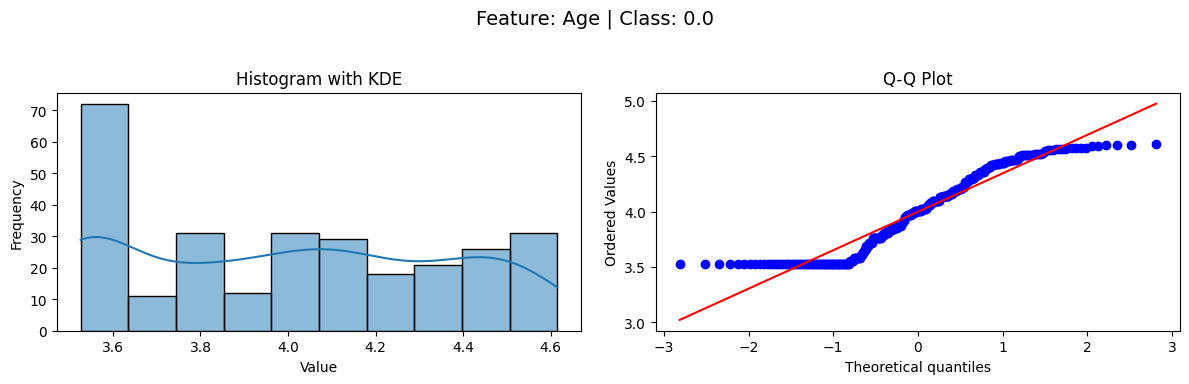

  Class: 1.0 | KS Statistic: 0.1144, p-value: 0.0499
    The feature Age is not Gaussian.


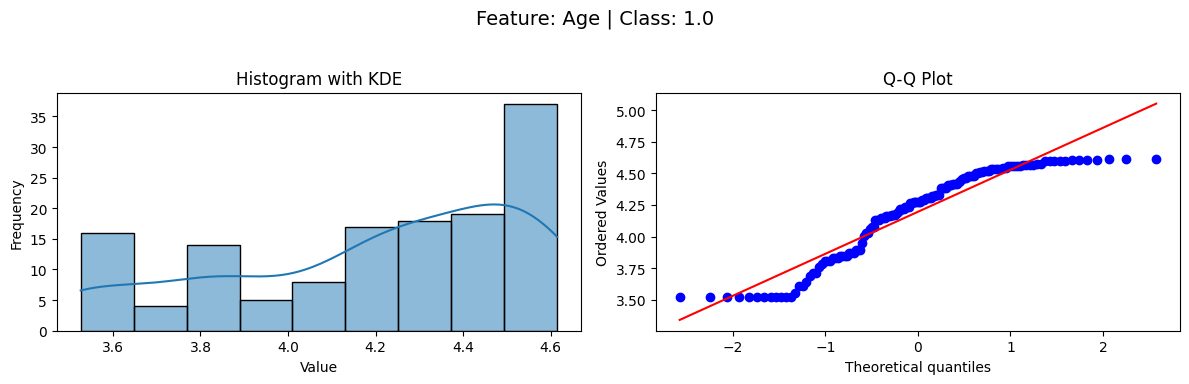

Checking if MonthlySalary is Gaussian...
  Class: 0.0 | KS Statistic: 0.1148, p-value: 0.0011
    The feature MonthlySalary is not Gaussian.


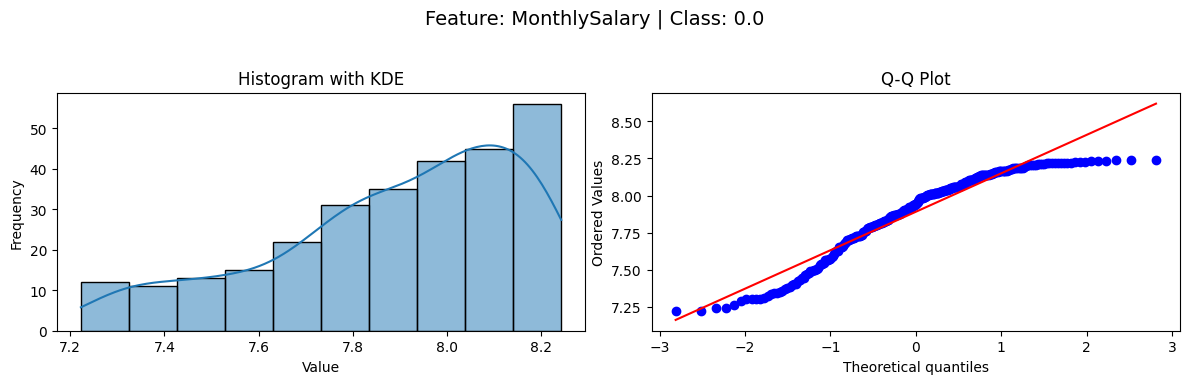

  Class: 1.0 | KS Statistic: 0.0406, p-value: 0.9698
    The feature MonthlySalary is likely Gaussian.


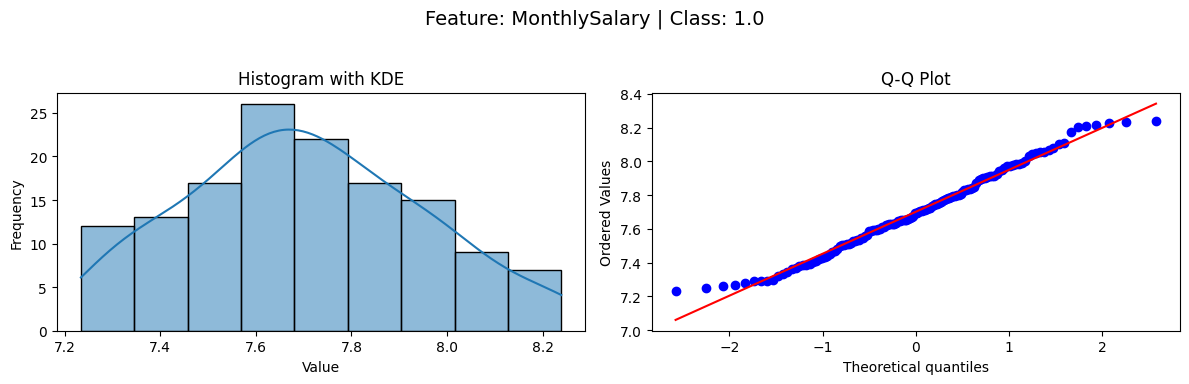

Only 1 out of 4 continuous features are Gaussian.


In [ ]:
def modify_to_log(X, continuous_features):
    X_log = X.copy()  # Create a copy of the DataFrame to avoid modifying the original
    for feature in continuous_features:
        # Apply log transformation, adding a small constant to avoid log(0)
        X_log[feature] = np.log(X[feature] + 1e-9)  # Adding a small constant to avoid log(0)
    return X_log

# Modify the continuous features to use log transformation
X_train_log = modify_to_log(X_train, continuous_features)

# Check if the log-transformed continuous features follow a Gaussian distribution
gaussian_log = check_if_gaussian(continuous_features, X_train_log, y_train)

'''
After examining the distribution of the log-transformed data, we found 
that the continuous features still did not follow a Gaussian distribution. 
In fact, the transformation made it worse, while two features originally 
followed a Gaussian distribution, only one did so after the log transformation. 
As a result, we decided not to apply the log transformation and chose to 
work with the original continuous features instead, using alternative 
methods to handle their non-Gaussian nature.
'''

### Discretization-Based Naive Bayes

Discretization transforms continuous features into categorical values by dividing their range into **bins** (e.g., equal-width or quantile-based). In the context of Naive Bayes, this allows the model to treat all features as discrete and estimate conditional probabilities using **frequency counts** rather than probability density functions.

This approach avoids assumptions about the underlying distribution of the data and is particularly useful when the features do not follow a known or smooth distribution.

However, it may lead to **information loss** if the number of bins is too small or the binning strategy is not well suited to the data. The effectiveness of this method depends on the choice of binning technique and the number of bins.

Below, we discretize each continuous feature into a fixed number of bins and store the bin intervals used for reference.


In [530]:
def discretize_continuous_features(X, continuous_features, bins=10):
    X_discretized = X.copy()
    bin_info = {}  # To store bin intervals for each feature
    
    for feature in continuous_features:
        # Discretize and return the bins used
        X_discretized[feature], bins_used = pd.cut(
            X[feature], 
            bins=bins, 
            labels=False,
            retbins=True
        )
        bin_info[feature] = bins_used
    
    return X_discretized, bin_info

# Discretize continuous features and get bin intervals
X_discretized, bin_intervals = discretize_continuous_features(X_train, continuous_features)

print('Bin intervals for each feature:')
for feature, intervals in bin_intervals.items():
    print(f'Feature: {feature}')
    for i in range(len(intervals)-1):
        print(f'  Bin {i}: [{intervals[i]:.2f}, {intervals[i+1]:.2f})')
    print()

Bin intervals for each feature:
Feature: Age
  Bin 0: [33.93, 40.70)
  Bin 1: [40.70, 47.40)
  Bin 2: [47.40, 54.10)
  Bin 3: [54.10, 60.80)
  Bin 4: [60.80, 67.50)
  Bin 5: [67.50, 74.20)
  Bin 6: [74.20, 80.90)
  Bin 7: [80.90, 87.60)
  Bin 8: [87.60, 94.30)
  Bin 9: [94.30, 101.00)

Feature: MonthlySalary
  Bin 0: [1367.57, 1613.00)
  Bin 1: [1613.00, 1856.00)
  Bin 2: [1856.00, 2099.00)
  Bin 3: [2099.00, 2342.00)
  Bin 4: [2342.00, 2585.00)
  Bin 5: [2585.00, 2828.00)
  Bin 6: [2828.00, 3071.00)
  Bin 7: [3071.00, 3314.00)
  Bin 8: [3314.00, 3557.00)
  Bin 9: [3557.00, 3800.00)



#### Discretizing a New Instance

Once the continuous features in the training data have been discretized into bins, any new instance must also be transformed using the **same bin intervals**. This ensures consistency between training and prediction.

The `discretize_instance` function maps each continuous value in the instance to its corresponding bin index based on the precomputed bin intervals. This enables the model to treat the new instance as purely categorical, allowing probability lookup using frequency counts.

This step is critical for making accurate predictions using a Naive Bayes classifier trained on discretized features.

In [531]:
def discretize_instance(instance, continuous_features, bin_intervals):
    # Make a copy of the instance dictionary to avoid modifying the original
    instance_discretized = instance.copy()
    
    # Loop over each continuous feature to discretize its value
    for feature in continuous_features:
        value = instance[feature]  # The actual value of the feature in this instance
        bins = bin_intervals[feature]  # The bin edges determined during training
        
        bin_index = None  # Initialize bin index as None
        
        # Find which bin the value falls into by checking intervals between bin edges
        for i in range(len(bins) - 1):
            # If value is greater or equal to the lower bound and less than the upper bound of bin i
            if bins[i] <= value < bins[i + 1]:
                bin_index = i
                break
        
        # Handle values outside the bin range (outliers or unseen values)
        if bin_index is None:
            # If value is smaller than the lowest bin edge, assign to first bin (index 0)
            if value < bins[0]:
                bin_index = 0
            # If value is greater than or equal to the highest bin edge, assign to last bin
            elif value >= bins[-1]:
                bin_index = len(bins) - 2
            else:
                # Fallback case (very rare) — assign to first bin just to be safe
                bin_index = 0
        
        # Replace the continuous feature value in the instance with the bin index
        instance_discretized[feature] = bin_index
    
    # Return the modified instance with discretized continuous features
    return instance_discretized

#### Prediction with Discretized Features

After discretizing continuous features and training a Naive Bayes classifier on categorical data, we can predict the class of a new instance using only frequency-based likelihoods.

The `predict_discretized` function performs the following steps:
- Computes the likelihood of the instance's discrete features for each class.
- Multiplies these likelihoods by the class priors to obtain posterior probabilities.
- Selects the class with the highest posterior as the predicted label.

This approach relies entirely on categorical (discrete) features, making it simple and robust, especially for datasets where continuous distributions are irregular or hard to model parametrically.

In [532]:
def predict_discretized(instance, prior_prob, X, y, discrete_features):
    # Compute likelihoods for the discrete features of the instance
    prob_discrete = conditional_probabilities_discrete(X, y, discrete_features)
    likelihoods_discrete = likelihood_discrete(prob_discrete, X, y, instance)

    print('Likelihoods for discrete features:')
    for decision, prob in likelihoods_discrete.items():
        print(f'  P(Decision={decision} | Instance) = {prob}')
    print()

    # Multiply the likelihoods by the prior probabilities to get the posterior probabilities
    posterior_probabilities = {}
    for decision in y.unique():
        posterior_probabilities[decision] = likelihoods_discrete[decision] * prior_prob[decision]

    print('Posterior probabilities for the instance:')
    for decision, prob in posterior_probabilities.items():
        print(f'  P(Decision={decision} | Instance) = {prob}')
    print()

    # Determine the class with the highest posterior probability
    predicted_class = max(posterior_probabilities, key=posterior_probabilities.get)
    print(f'Predicted class for the instance: {predicted_class}')

    return predicted_class

### Gaussian Mixture Models (GMM)

A Gaussian Mixture Model (GMM) extends the idea of modeling continuous features with a single Gaussian by using a weighted sum of multiple Gaussians. This allows it to capture more complex distributions that may be multimodal or skewed.

In a classification context, a separate GMM is fitted for each class and each continuous feature. These models estimate the probability density function (PDF) of the feature values within each class.

The function below trains a GMM for every combination of class and continuous feature, using a specified number of components (i.e., Gaussian distributions). This approach provides more flexibility than assuming a single Gaussian per feature.

In [533]:
def train_gmm(X, y, continuous_features, n_components=2):
    gmms = {}  # Initialize an empty dictionary to store GMMs for each feature

    for feature in continuous_features:
        gmms[feature] = {}

        for decision in y.unique():
            subset = X[y == decision][feature].values.reshape(-1, 1)  # Reshape for GMM input

            # Fit a Gaussian Mixture Model to the subset of data for the current feature and decision
            gmm = GaussianMixture(n_components=n_components, random_state=42)  # Initialize GMM with specified number of components
            gmm.fit(subset)  # Fit the GMM to the data

            gmms[feature][decision] = gmm  # Store the fitted GMM in the dictionary

    return gmms

gmms = train_gmm(X_train, y_train, continuous_features)

#### Likelihood Estimation with Gaussian Mixture Models

After training a Gaussian Mixture Model (GMM) for each class and continuous feature, we can estimate the likelihood of a new instance by evaluating the probability of each feature value under the corresponding GMM.

This function calculates the total likelihood of an instance for each class by:
- Retrieving the GMM associated with each feature and class.
- Computing the probability of the feature value under the GMM using the log-likelihood (`score_samples`) and exponentiating it.
- Multiplying the resulting probabilities across all continuous features to obtain the overall likelihood for each class.

This approach allows for flexible and expressive modeling of continuous feature distributions, especially when they are not well-described by a single Gaussian.

In [534]:
def likelihood_continuous_gmm(gmms, instance, y, continuous_features):
    likelihoods = {}  # Initialize a dictionary to store likelihoods for each class

    # Iterate over each unique decision in y to calculate likelihoods
    for decision in y.unique():
        likelihoods[decision] = 1  # Start with a likelihood of 1 for each decision

        # For each continuous feature, multiply the likelihood by the GMM probability
        for feature in continuous_features:
            gmm = gmms[feature][decision]  # Get the GMM for the current feature and decision

            value = np.array([[instance[feature]]])  # Reshape the value for GMM input
            log_prob = gmm.score_samples(value)[0]  # Get the log probability of the value under the GMM
            prob = np.exp(log_prob)  # Convert log probability to normal probability

            likelihoods[decision] *= prob  # Multiply by the GMM probability for this feature and decision
    
    return likelihoods

#### Prediction Using Gaussian Mixture Models (GMM) and Discrete Features

This function performs classification of a given instance by combining likelihoods from both discrete and continuous features:

- It first computes the likelihoods of the discrete features using precomputed conditional probabilities.
- Then, it calculates the likelihoods of the continuous features by evaluating the instance’s feature values against the trained Gaussian Mixture Models (GMMs) for each class.
- The likelihoods from discrete and continuous features are combined by multiplication to obtain the overall likelihood for each class.
- These combined likelihoods are then multiplied by the prior class probabilities to compute the posterior probabilities.
- Finally, the class with the highest posterior probability is chosen as the predicted class.

This approach leverages the flexibility of GMMs to model complex continuous feature distributions, while also incorporating discrete feature information for more accurate classification.

In [535]:
def predict_gmm(instance, prior_prob, X, y, discrete_features, continuous_features, gmms):
    # Compute likelihoods for the discrete features of the instance
    prob_discrete = conditional_probabilities_discrete(X, y, discrete_features)
    likelihoods_discrete = likelihood_discrete(prob_discrete, X, y, instance)

    print('Likelihoods for discrete features:')
    for decision, prob in likelihoods_discrete.items():
        print(f'  P(Decision={decision} | Instance) = {prob}')
    print()

    # Calculate the likelihood for the continuous features using GMM
    likelihoods_continuous = likelihood_continuous_gmm(gmms, instance, y, continuous_features)

    print('Likelihoods for continuous features using GMM:')
    for decision, prob in likelihoods_continuous.items():
        print(f'  P(Decision={decision} | Instance) = {prob}')
    print()

    # Combine the likelihoods from discrete and continuous features
    combined_likelihoods = {}
    for decision in y.unique():
        combined_likelihoods[decision] = likelihoods_discrete[decision] * likelihoods_continuous[decision]
    
    print('Combined likelihoods for the instance:')
    for decision, prob in combined_likelihoods.items():
        print(f'  P(Decision={decision} | Instance) = {prob}')
    print()

    # Multiply the combined likelihoods by the prior probabilities to get the posterior probabilities
    posterior_probabilities = {}
    for decision in y.unique():
        posterior_probabilities[decision] = combined_likelihoods[decision] * prior_prob[decision]

    print('Posterior probabilities for the instance:')
    for decision, prob in posterior_probabilities.items():
        print(f'  P(Decision={decision} | Instance) = {prob}')
    print()

    # Determine the class with the highest posterior probability
    predicted_class = max(posterior_probabilities, key=posterior_probabilities.get)
    print(f'Predicted class for the instance: {predicted_class}')

    return predicted_class

### Kernel Density Estimation (KDE)  

Kernel Density Estimation is a non-parametric method to estimate the probability density function of a continuous variable. Unlike Gaussian Mixture Models, KDE does not assume a fixed number of underlying distributions or any specific parametric form. Instead, it smooths the data points using a kernel function, commonly a Gaussian kernel, and a bandwidth parameter that controls the smoothness of the resulting density estimate.  

KDE is flexible and can model complex distributions, but its performance depends heavily on the choice of bandwidth. Smaller bandwidths capture more detail but may overfit noise, while larger bandwidths produce smoother estimates but may miss important features in the data.  

This approach is especially useful when the true underlying distribution is unknown or does not fit common parametric models.  

In [536]:
def fit_kde(X, y, continuous_features, bandwidth=2.0):
    kde_models = {}  # Initialize an empty dictionary to store KDE models for each feature

    for feature in continuous_features:
        kde_models[feature] = {}

        for decision in y.unique():
            subset = X[y == decision][feature].values.reshape(-1, 1)  # Reshape for KDE input

            # Fit a Kernel Density Estimation model to the subset of data for the current feature and decision
            kde = KernelDensity(kernel='gaussian', bandwidth=bandwidth)  # Initialize KDE with Gaussian kernel
            kde.fit(subset)  # Fit the KDE to the data
            
            kde_models[feature][decision] = kde  # Store the fitted KDE in the dictionary

    return kde_models

kde_models = fit_kde(X_train, y_train, continuous_features)

#### Likelihood Calculation Using KDE  

This function computes the likelihood of a given instance's continuous features for each class based on Kernel Density Estimation (KDE) models. For each class and continuous feature, it evaluates the KDE to obtain the log-probability of the feature's value, converts it to a normal probability, and multiplies these probabilities across all continuous features. The result is the overall likelihood of the instance belonging to each class under the KDE model.

In [537]:
def likelihood_continuous_kde(kde_models, instance, y, continuous_features):
    likelihoods = {}  # Initialize a dictionary to store likelihoods for each class

    # Iterate over each unique decision in y to calculate likelihoods
    for decision in y.unique():
        likelihoods[decision] = 1  # Start with a likelihood of 1 for each decision

        # For each continuous feature, multiply the likelihood by the KDE probability
        for feature in continuous_features:
            kde = kde_models[feature][decision]  # Get the KDE for the current feature and decision

            value = np.array([[instance[feature]]])  # Reshape the value for KDE input
            log_prob = kde.score_samples(value)[0]  # Get the log probability of the value under the KDE
            prob = np.exp(log_prob)  # Convert log probability to normal probability

            likelihoods[decision] *= prob  # Multiply by the KDE probability for this feature and decision
    
    return likelihoods

#### Prediction Using KDE-Based Naive Bayes  

This function predicts the class label of a given instance by combining likelihoods computed from both discrete and continuous features. Discrete feature likelihoods are calculated from precomputed conditional probabilities, while continuous feature likelihoods are estimated using Kernel Density Estimation (KDE) models. The function multiplies these likelihoods with the prior probabilities to obtain posterior probabilities for each class and returns the class with the highest posterior probability. Throughout the process, it prints detailed likelihood and posterior values for transparency.

In [538]:
def predict_kde(instance, prior_prob, X, y, discrete_features, continuous_features, kde_models):
    # Compute likelihoods for the discrete features of the instance
    prob_discrete = conditional_probabilities_discrete(X, y, discrete_features)
    likelihoods_discrete = likelihood_discrete(prob_discrete, X, y, instance)

    print('Likelihoods for discrete features:')
    for decision, prob in likelihoods_discrete.items():
        print(f'  P(Decision={decision} | Instance) = {prob}')
    print()

    # Calculate the likelihood for the continuous features using KDE
    likelihoods_continuous = likelihood_continuous_kde(kde_models, instance, y, continuous_features)

    print('Likelihoods for continuous features using KDE:')
    for decision, prob in likelihoods_continuous.items():
        print(f'  P(Decision={decision} | Instance) = {prob}')
    print()

    # Combine the likelihoods from discrete and continuous features
    combined_likelihoods = {}
    for decision in y.unique():
        combined_likelihoods[decision] = likelihoods_discrete[decision] * likelihoods_continuous[decision]
    
    print('Combined likelihoods for the instance:')
    for decision, prob in combined_likelihoods.items():
        print(f'  P(Decision={decision} | Instance) = {prob}')
    print()

    # Multiply the combined likelihoods by the prior probabilities to get the posterior probabilities
    posterior_probabilities = {}
    for decision in y.unique():
        posterior_probabilities[decision] = combined_likelihoods[decision] * prior_prob[decision]

    print('Posterior probabilities for the instance:')
    for decision, prob in posterior_probabilities.items():
        print(f'  P(Decision={decision} | Instance) = {prob}')
    print()

    # Determine the class with the highest posterior probability
    predicted_class = max(posterior_probabilities, key=posterior_probabilities.get)
    print(f'Predicted class for the instance: {predicted_class}')

    return predicted_class

### Unified Prediction Function with Multiple Continuous Feature Models

This function `posterior` provides a flexible way to predict the class of an instance using Naive Bayes, supporting different models for continuous features:

- If `gaussian=True`, it uses the Gaussian (Normal) distribution with mean and standard deviation to compute likelihoods.
- If `gaussian=False`, it supports three alternatives for modeling continuous features:
  - `'D'`: Discretizes continuous features into bins and treats them as categorical.
  - `'GMM'`: Uses Gaussian Mixture Models to estimate likelihoods.
  - `'KDE'`: Uses Kernel Density Estimation for likelihood estimation.

The function automatically discretizes the instance if needed, and combines discrete and continuous feature likelihoods with prior probabilities to predict the most probable class. It prints which model is used and outputs detailed predictions for each instance.

The example loop shows how to apply this function over a test dataset, predicting and printing the class for each instance.

In [539]:
instances = X_test.to_dict(orient='records')

def posterior(instance, prior_prob, X, y, discrete_features, continuous_features, gaussian=True, cont=None):
    if gaussian:
        print("Using Gaussian distribution for continuous features.")

        predicted_class = predict_gaussian(instance, prior_prob, X, y, discrete_features, continuous_features, mean_std)  # Predict using Gaussian distribution

    else:
        print("Using non-Gaussian distribution for continuous features.")
        if cont == 'D':
            X = X_discretized  # Use the discretized version of X

            all_discrete_features = discrete_features + continuous_features  # Combine discrete and continuous features for discretization

            instance = discretize_instance(instance, continuous_features, bin_intervals)  # Discretize the instance
            predicted_class = predict_discretized(instance, prior_prob, X, y, all_discrete_features)  # Predict using discretized features

        elif cont == 'GMM':
            predicted_class = predict_gmm(instance, prior_prob, X, y, discrete_features, continuous_features, gmms)

        elif cont == 'KDE':
            predicted_class = predict_kde(instance, prior_prob, X, y, discrete_features, continuous_features, kde_models)

    return predicted_class

predicted = []
for instance in instances:
    predicted_class = posterior(instance, prior_prob, X_train, y_train, discrete_features, continuous_features, gaussian, cont='GMM')
    predicted.append(predicted_class)
    print('-' * 50)

Using non-Gaussian distribution for continuous features.
Likelihoods for discrete features:
  P(Decision=0.0 | Instance) = 0.010298745119200764
  P(Decision=1.0 | Instance) = 0.01197400401894

Likelihoods for continuous features using GMM:
  P(Decision=0.0 | Instance) = 1.6040089077935232e-06
  P(Decision=1.0 | Instance) = 8.527857687762738e-06

Combined likelihoods for the instance:
  P(Decision=0.0 | Instance) = 1.6519278910293093e-08
  P(Decision=1.0 | Instance) = 1.021126022262194e-07

Posterior probabilities for the instance:
  P(Decision=0.0 | Instance) = 1.1091515839768219e-08
  P(Decision=1.0 | Instance) = 3.355128358861494e-08

Predicted class for the instance: 1.0
--------------------------------------------------
Using non-Gaussian distribution for continuous features.
Likelihoods for discrete features:
  P(Decision=0.0 | Instance) = 0.04971023482388186
  P(Decision=1.0 | Instance) = 0.0053242301900388945

Likelihoods for continuous features using GMM:
  P(Decision=0.0 | Ins

### Accuracy Calculation

This function `compute_accuracy` calculates the classification accuracy as the percentage of correctly predicted instances compared to the true labels.

- It iterates through pairs of predicted and true labels, counts how many predictions are correct, and then computes the accuracy percentage.
- The result is printed formatted to two decimal places.

This simple metric provides a straightforward way to evaluate the overall performance of the classification model.

In [540]:
# Compute accuracy
def compute_accuracy(predicted, y):
    correct_predictions = sum(1 for p, t in zip(predicted, y) if p == t)  # Count correct predictions
    accuracy = correct_predictions / len(y) * 100  # Calculate accuracy as a percentage
    return accuracy

In [541]:
def score_point(instance):
    age = instance['Age']
    health_condition = instance['ChronicDiseases']
    financial_situation = instance['MonthlySalary']
    family_responsibilities = instance['NumberOfChildren']

    # Scoring based on age
    if age < 30:
        age_score = 5
    elif 30 <= age < 40:
        age_score = 10
    elif 40 <= age < 50:
        age_score = 15
    else:
        age_score = 20

    # Scoring based on health condition
    if health_condition == 0:
        health_score = 5
    elif health_condition == 1:
        health_score = 10
    else:
        health_score = 15

    # Scoring based on financial situation
    if financial_situation > 3500:
        financial_score = 5
    elif 1700 < financial_situation <= 3500:
        financial_score = 10
    else:
        financial_score = 15

    # Scoring based on family responsibilities
    if family_responsibilities == 0:
        family_score = 5
    elif family_responsibilities == 1:
        family_score = 10
    else:
        family_score = 15

    # Calculate total score
    total_score = age_score + health_score + financial_score + family_score

    if total_score > 50:
        score = 1
    else:
        score = 0

    return score

total_scores = []
for instance in instances:
    score = score_point(instance)  # Calculate the score for the instance
    total_scores.append(score)  # Append the score to the list

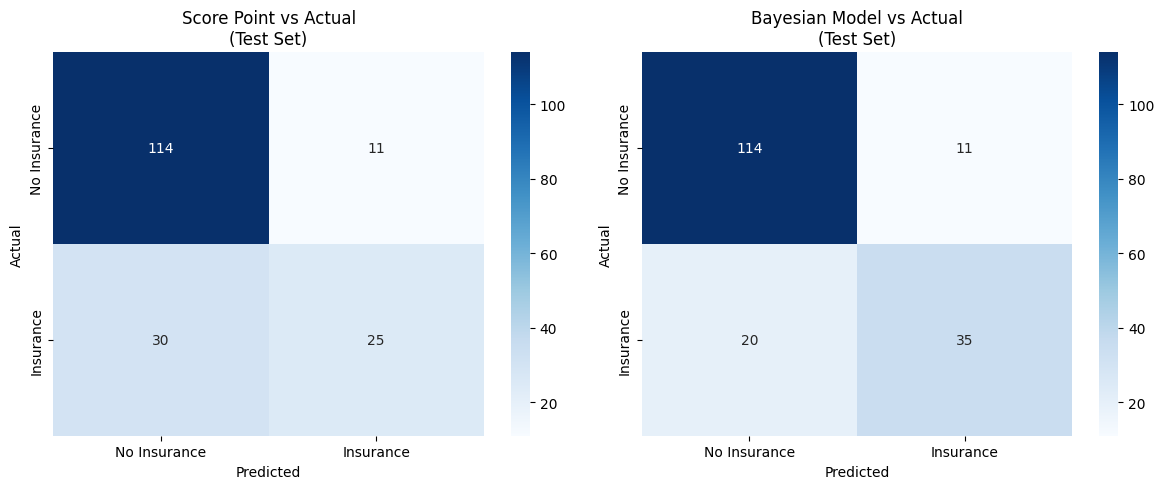

Score Point Accuracy: 77.22%
Bayesian Model Accuracy: 82.78%


In [542]:
# Create confusion matrices
score_cm = confusion_matrix(y_test, total_scores)
bayes_cm = confusion_matrix(y_test, predicted)

# Plot confusion matrices with Blues color palette
plt.figure(figsize=(12, 5))

# Score Point Confusion Matrix
plt.subplot(1, 2, 1)
sns.heatmap(score_cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['No Insurance', 'Insurance'],
            yticklabels=['No Insurance', 'Insurance'])
plt.title('Score Point vs Actual\n(Test Set)')
plt.xlabel('Predicted')
plt.ylabel('Actual')

# Bayesian Model Confusion Matrix
plt.subplot(1, 2, 2)
sns.heatmap(bayes_cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Insurance', 'Insurance'],
            yticklabels=['No Insurance', 'Insurance'])
plt.title('Bayesian Model vs Actual\n(Test Set)')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.tight_layout()
plt.show()

# Print accuracy metrics
print(f"Score Point Accuracy: {compute_accuracy(total_scores, y_test):.2f}%")
print(f"Bayesian Model Accuracy: {compute_accuracy(predicted, y_test):.2f}%")